In [1]:
import numpy as np
import torch
import torchvision
import torchmetrics
import lightning.pytorch as pl 
from torchinfo import summary 
from torchview import draw_graph 
import matplotlib.pyplot as plt 
import pandas as pd

if (torch.cuda.is_available()): 
    device = ("cuda")
else:
    device = ("cpu")
print(f"Use GPU: {torch.cuda.is_available()}")

Use GPU: True


In [8]:
# Config Section
cfg_data_folder = "datasets/cifar100"
cfg_max_epochs  = 50;
cfg_num_workers = 2
cfg_hidden_dims = 42

cfg_logger_dir="logs"
cfg_logger_name="OL2"
cfg_logger_version="single"

In [9]:
# Load the data set and scale to [-1,+1]
training_dataset = torchvision.datasets.CIFAR100(root=cfg_data_folder, download=True, train=True)
testing_dataset = torchvision.datasets.CIFAR100(root=cfg_data_folder,  download=True, train=False) 

x_train = (torch.Tensor(training_dataset.data) / 127.5) - 1.0
y_train = torch.Tensor(training_dataset.targets).to(torch.long)
x_test = (torch.Tensor(testing_dataset.data) / 127.5) - 1.0 
y_test = torch.Tensor(testing_dataset.targets).to(torch.long)

# You can set a seed value here if you
# want to control the shuffling process...
rng = np.random.default_rng()
permutation = rng.permutation(x_train.shape[0]) 
split_point = int(x_train.shape[0] * 0.8) # 80%/20% split

# Split into validation/training - keep test # set aside for later...
x_val = x_train[permutation][split_point:]
y_val = y_train[permutation][split_point:]
x_train = x_train[permutation][:split_point]
y_train = y_train[permutation][:split_point]

print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

Files already downloaded and verified
Files already downloaded and verified
torch.Size([40000, 32, 32, 3])
torch.Size([10000, 32, 32, 3])
torch.Size([10000, 32, 32, 3])


In [10]:
x_train.shape

torch.Size([40000, 32, 32, 3])

In [5]:
# Show how many labels.
y_train.shape

torch.Size([40000])

In [6]:
# Show the Classes
np.unique(y_train)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

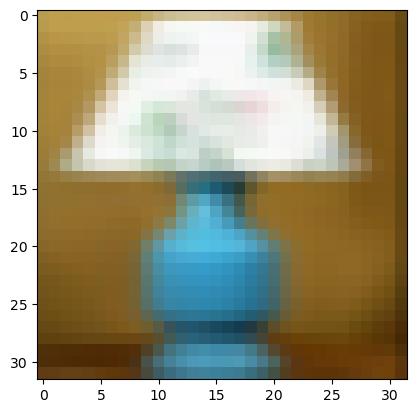

In [11]:
plt.imshow((x_train[0].detach().numpy() + 1.0)/2.0)
plt.show()

In [12]:
x_train.shape[1:].numel()

3072

In [195]:
class SingleLayerNetwork(torch.nn.Module): 
    def __init__(self, input_size, output_size, **kwargs):
        super().__init__(**kwargs)
        self.flatten_layer = torch.nn.Flatten() 
        self.dropout = torch.nn.Dropout(p=0.5)
        self.batch_norm = torch.nn.BatchNorm1d(output_size)
        self.output_layer = torch.nn.Linear(input_size.numel(), output_size)
                                            
    def forward(self, x):
        y = x
        y = self.flatten_layer(y) 
        y = self.dropout(y)
        y = self.output_layer(y)
        y = self.batch_norm(y)
        return y
    
    def predict(self, x): 
        y = x
        y = self.forward(y)
        y = torch.softmax(y, -1) 
        return y
    
        
# Define Trainable Module
class PLModel(pl.LightningModule):
    def __init__(self, module, **kwargs):
        # This is the contructor, where we typically make
        # layer objects using provided arguments. 
        super().__init__(**kwargs) # Call the super class constructor 
        self.module = module
        
        # This creates an accuracy function
        self.model_acc = torchmetrics.classification.Accuracy(task='multiclass', 
                                                              num_classes=module.output_layer.out_features)
        # This creates a loss function
        self.model_loss = torch.nn.CrossEntropyLoss()
    
    def forward(self, x):
        return self.module.forward(x) 
        
    def predict(self, x):
        return self.module.predict(x)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.01, weight_decay=1e-4)
        return optimizer

    def training_step(self, train_batch, batch_idx): 
        x, y_true = train_batch
        y_pred = self(x)
        acc = self.model_acc(y_pred, y_true)
        loss = self.model_loss(y_pred, y_true) 
        self.log('train_acc',  acc,  on_step=False, on_epoch=True)
        self.log('train_loss', loss, on_step=False, on_epoch=True) 
        return loss


    def validation_step(self, val_batch, batch_idx): 
        x, y_true = val_batch
        y_pred = self(x)
        acc = self.model_acc(y_pred, y_true)
        loss = self.model_loss(y_pred, y_true)
        self.log('val_acc',  acc,  on_step=False, on_epoch=True)
        self.log('val_loss', loss, on_step=False, on_epoch=True)
        return loss
        
    def test_step(self, test_batch, batch_idx):
        x, y_true = test_batch
        y_pred = self(x)
        acc = self.model_acc(y_pred,y_true)
        loss = self.model_loss(y_pred,y_true)
        self.log('test_acc',  acc,  on_step=False, on_epoch=True)
        self.log('test_loss', loss, on_step=False, on_epoch=True)
        return loss


In [196]:
model = PLModel(SingleLayerNetwork(x_train.shape[1:],
                                   len(y_train.unique())))

In [197]:
summary(model, input_size=(1,) + x_train.shape[1:])

Layer (type:depth-idx)                   Output Shape              Param #
PLModel                                  [1, 100]                  --
├─SingleLayerNetwork: 1-1                --                        --
│    └─Flatten: 2-1                      [1, 3072]                 --
│    └─Dropout: 2-2                      [1, 3072]                 --
│    └─Linear: 2-3                       [1, 100]                  307,300
│    └─BatchNorm1d: 2-4                  [1, 100]                  200
Total params: 307,500
Trainable params: 307,500
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.31
Input size (MB): 0.01
Forward/backward pass size (MB): 0.00
Params size (MB): 1.23
Estimated Total Size (MB): 1.24

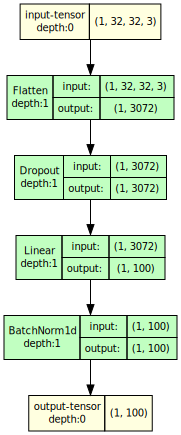

In [198]:
model_graph = draw_graph(model, 
                         input_size=(1,) + x_train.shape[1:],
                         device=device,
                         depth=1)
model_graph.visual_graph

In [199]:
predictions = model.predict(x_train[:5].to(device)).cpu().detach().numpy()

predictions

array([[0.0292787 , 0.00548388, 0.00623345, 0.01279485, 0.01374502,
        0.03961928, 0.00094384, 0.01190403, 0.00150755, 0.00732674,
        0.01892196, 0.0371431 , 0.01257053, 0.00544901, 0.00573541,
        0.0014126 , 0.02437359, 0.00101864, 0.0034793 , 0.00221201,
        0.03394362, 0.02673179, 0.00439086, 0.00311659, 0.00247107,
        0.00284593, 0.00710238, 0.02247068, 0.02538407, 0.00515349,
        0.00629899, 0.00427479, 0.00314865, 0.00270499, 0.00819915,
        0.00594198, 0.01354489, 0.0055588 , 0.01186129, 0.00581759,
        0.01936972, 0.00501508, 0.00820225, 0.03331175, 0.00208708,
        0.0020773 , 0.01803007, 0.01028707, 0.01269905, 0.01564957,
        0.00321865, 0.00544243, 0.02526488, 0.02968713, 0.01872906,
        0.008842  , 0.00160254, 0.01106203, 0.00890453, 0.00255996,
        0.00518412, 0.00144282, 0.0074089 , 0.00211886, 0.00900256,
        0.01557224, 0.00334025, 0.00240926, 0.02295439, 0.00912527,
        0.00844008, 0.01576132, 0.00434601, 0.00

In [200]:
predictions.shape

(5, 100)

In [201]:
predictions.argmax(-1)

array([ 5, 91, 62, 14, 24])

In [202]:
y_train[:5]

tensor([40, 44, 27, 28, 40])

In [203]:
model.model_loss(model(x_train[:5].to(device)),
                 y_train[:5].to(device)
                ).cpu().detach().numpy()

array(5.6309576, dtype=float32)

In [204]:
model.model_acc(model(x_train[:5].to(device)),
                y_train[:5].to(device)).cpu().detach().numpy()

array(0., dtype=float32)

In [205]:
xy_train = torch.utils.data.DataLoader(list(zip(x_train, y_train)),
                                       shuffle=True,
                                       batch_size=250,
                                       num_workers=cfg_num_workers) # Using CFG

xy_val = torch.utils.data.DataLoader(list(zip(x_val, y_val)),
                                     shuffle=False,
                                     batch_size=250,
                                     num_workers=cfg_num_workers) # Using CFG

xy_test = torch.utils.data.DataLoader(list(zip(x_test, y_test)),
                                      shuffle=False,
                                      batch_size=250,
                                      num_workers=cfg_num_workers) # Using CFG

In [206]:
# Setup Logger
logger = pl.loggers.CSVLogger("logs", name="OL2", version="single")

In [207]:
trainer = pl.Trainer(logger=logger,
                     max_epochs=cfg_max_epochs,
                     enable_progress_bar=True,
                     log_every_n_steps=0,
                     callbacks=[pl.callbacks.TQDMProgressBar(refresh_rate=20)])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [208]:
trainer.validate(model, xy_val)

/opt/conda/lib/python3.11/site-packages/lightning/fabric/loggers/csv_logs.py:195: UserWarning: Experiment logs directory logs/OL2/single exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.
/opt/conda/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃  Runningstage.validating  ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │   0.010200000368058681    │
│         val_loss          │     4.654328346252441     │
└───────────────────────────┴───────────────────────────┘

[{'val_acc': 0.010200000368058681, 'val_loss': 4.654328346252441}]

In [209]:
# Train Model -  This takes awhile!!!
trainer.fit(model, xy_train, xy_val)

/opt/conda/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:617: UserWarning: Checkpoint directory logs/OL2/single/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type               | Params
--------------------------------------------------
0 | module     | SingleLayerNetwork | 307 K 
1 | model_acc  | MulticlassAccuracy | 0     
2 | model_loss | CrossEntropyLoss   | 0     
--------------------------------------------------
307 K     Trainable params
0         Non-trainable params
307 K     Total params
1.230     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Sanity Checking: 0it [00:00, ?it/s]

/opt/conda/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


In [210]:
# Validate on Model
trainer.validate(model, xy_val)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃  Runningstage.validating  ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.1655000001192093     │
│         val_loss          │     3.713045358657837     │
└───────────────────────────┴───────────────────────────┘

[{'val_acc': 0.1655000001192093, 'val_loss': 3.713045358657837}]

In [211]:
results = pd.read_csv(logger.log_dir+"/metrics.csv")
results

,val_acc,val_loss,epoch,step,train_acc,train_loss
0,0.0102,4.654328,0,0,NaN,NaN
1,0.1461,3.822148,0,159,NaN,NaN
2,NaN,NaN,0,159,0.119075,4.011355
3,0.1515,3.754121,1,319,NaN,NaN
4,NaN,NaN,1,319,0.159950,3.745637
...,...,...,...,...,...,...
97,0.1610,3.712700,48,7839,NaN,NaN
98,NaN,NaN,48,7839,0.177100,3.632827
99,0.1655,3.713045,49,7999,NaN,NaN
100,NaN,NaN,49,7999,0.177675,3.626238


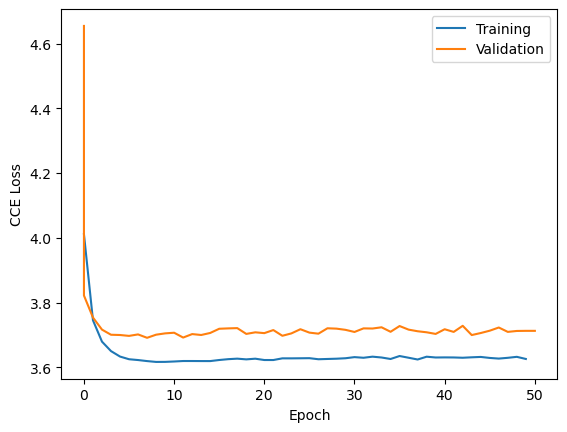

In [212]:
plt.plot(results["epoch"][np.logical_not(np.isnan(results["train_loss"]))],
         results["train_loss"][np.logical_not(np.isnan(results["train_loss"]))],
         label="Training")

plt.plot(results["epoch"][np.logical_not(np.isnan(results["val_loss"]))],
         results["val_loss"][np.logical_not(np.isnan(results["val_loss"]))],
         label="Validation")

plt.legend()
plt.ylabel("CCE Loss")
plt.xlabel("Epoch")
plt.show()


In [213]:
print("Validation accuracy:",*["%.8f"%(x) for x in results['val_acc'][np.logical_not(np.isnan(results["val_acc"]))]])

Validation accuracy: 0.01020000 0.14610000 0.15150000 0.16310000 0.16240001 0.16429999 0.16480000 0.16630000 0.16470000 0.15780000 0.16339999 0.16500001 0.16509999 0.16599999 0.15970001 0.16869999 0.16350000 0.16120000 0.16069999 0.15910000 0.16200000 0.16560000 0.16060001 0.16329999 0.16270000 0.16370000 0.16220000 0.16150001 0.16050000 0.16329999 0.15970001 0.16110000 0.15490000 0.16150001 0.16000000 0.15850000 0.15790001 0.15960000 0.15610000 0.15910000 0.16320001 0.16020000 0.16320001 0.16400000 0.16410001 0.16249999 0.16230001 0.16060001 0.16180000 0.16100000 0.16550000 0.16550000


In [214]:
print("Testing accuracy:", trainer.test(model, xy_test)[0]['test_acc'])

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.
/opt/conda/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.16419999301433563    │
│         test_loss         │    3.7282872200012207     │
└───────────────────────────┴───────────────────────────┘

Testing accuracy: 0.16419999301433563
